## Using Conv1D

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [ ]:
# for synthetic time series

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
# turn array of data to dataset for training

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# for forecasting after training

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
          lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 35s 43ms/step - loss: 73.1912 - mae: 73.6904
Epoch 2/100
8/8 [==============================] - 0s 32ms/step - loss: 72.4799 - mae: 72.9791
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 71.3446 - mae: 71.8437
Epoch 4/100
8/8 [==============================] - 0s 34ms/step - loss: 69.9230 - mae: 70.4223
Epoch 5/100
8/8 [==============================] - 0s 33ms/step - loss: 68.2678 - mae: 68.7669
Epoch 6/100
8/8 [==============================] - 0s 33ms/step - loss: 66.3621 - mae: 66.8609
Epoch 7/100
8/8 [==============================] - 0s 33ms/step - loss: 64.2432 - mae: 64.7424
Epoch 8/100
8/8 [==============================] - 0s 33ms/step - loss: 61.8749 - mae: 62.3738
Epoch 9/100
8/8 [==============================] - 0s 33ms/step - loss: 59.2491 - mae: 59.7479
Epoch 10/100
8/8 [==============================] - 0s 32ms/step - loss: 56.3267 - mae: 56.8254
Epoch 11/100
8/8 [==============================

(1e-08, 0.0001, 0.0, 30.0)

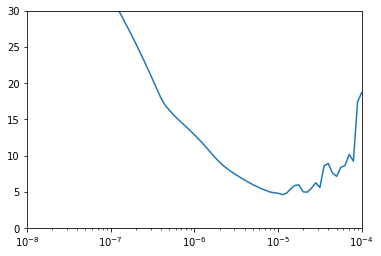

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
31/31 [==============================] - 4s 17ms/step - loss: 20.0714 - mae: 20.5646
Epoch 2/500
31/31 [==============================] - 1s 17ms/step - loss: 7.9198 - mae: 8.4048
Epoch 3/500
31/31 [==============================] - 1s 16ms/step - loss: 6.6716 - mae: 7.1533
Epoch 4/500
31/31 [==============================] - 1s 16ms/step - loss: 6.1672 - mae: 6.6476
Epoch 5/500
31/31 [==============================] - 1s 16ms/step - loss: 5.7151 - mae: 6.1946
Epoch 6/500
31/31 [==============================] - 1s 16ms/step - loss: 5.6170 - mae: 6.0971
Epoch 7/500
31/31 [==============================] - 1s 16ms/step - loss: 5.5150 - mae: 5.9948
Epoch 8/500
31/31 [==============================] - 1s 16ms/step - loss: 5.3878 - mae: 5.8675
Epoch 9/500
31/31 [==============================] - 1s 16ms/step - loss: 5.2866 - mae: 5.7651
Epoch 10/500
31/31 [==============================] - 1s 16ms/step - loss: 5.2029 - mae: 5.6827
Epoch 11/500
31/31 [===========================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

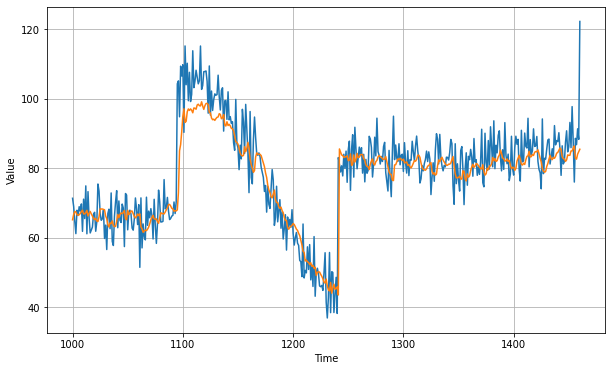

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0907254

<Figure size 432x288 with 0 Axes>

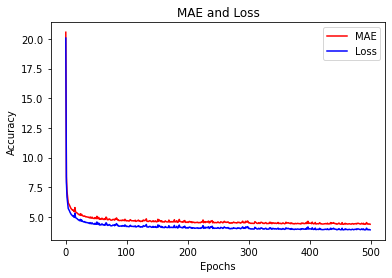

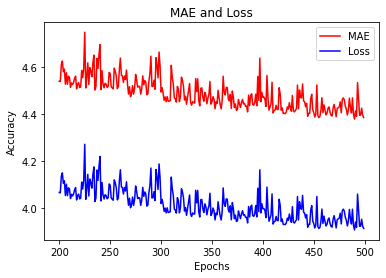

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Sunspots Data

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /content/sunspots.csv

--2021-08-25 04:03:17--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.184.128, 64.233.167.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.184.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/content/sunspots.csv’

/content/sunspots.c 100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-08-25 04:03:17 (91.8 MB/s) - ‘/content/sunspots.csv’ saved [70827/70827]



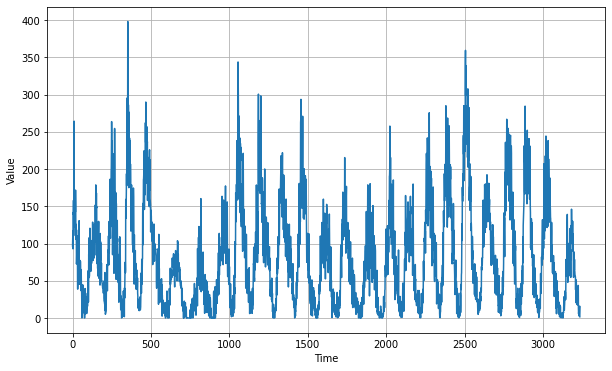

In [ ]:
import csv
time_step = []
sunspots = []

with open('/content/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)                                    # throwing away 1st line which has column headers
  for row in reader:
    sunspots.append(float(row[2]))                # taking sunspots data from col 2
    time_step.append(int(row[0]))                 # taking time steps data from col 1

# convert to arrays

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

# seasonality and noise present but no noticeable trend

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60                              # 60 months, each time slice is a month
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9))
model.fit(dataset, epochs=75, verbose=0)


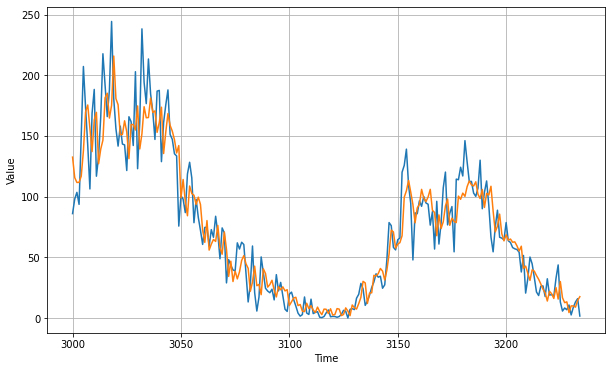

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.814828

## Sunspots Data - CNN + LSTM + Dense

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /content/sunspots.csv

--2021-08-25 04:15:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/content/sunspots.csv’

/content/sunspots.c 100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-08-25 04:15:46 (94.9 MB/s) - ‘/content/sunspots.csv’ saved [70827/70827]



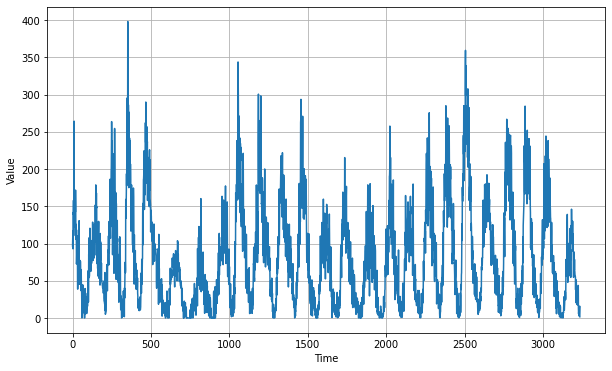

In [ ]:
import csv
time_step = []
sunspots = []

with open('/content/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

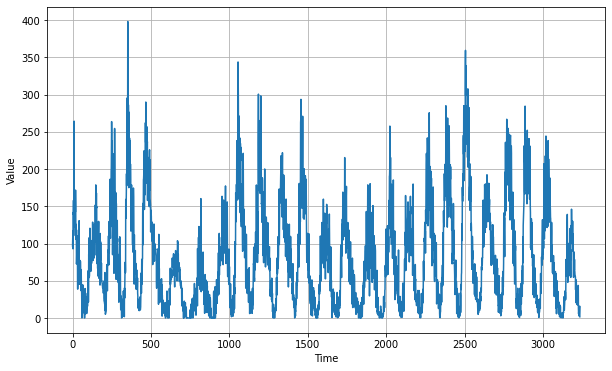

In [ ]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=75, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/75
12/12 [==============================] - 5s 48ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/75
12/12 [==============================] - 1s 52ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/75
12/12 [==============================] - 1s 54ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/75
12/12 [==============================] - 1s 54ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/75
12/12 [==============================] - 1s 54ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/75
12/12 [==============================] - 1s 54ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/75
12/12 [==============================] - 1s 54ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/75
12/12 [==============================] - 1s 56ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/75
12/12 [==============================] - 1s 57ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/75
12/12 [===============

(1e-08, 0.0001, 0.0, 60.0)

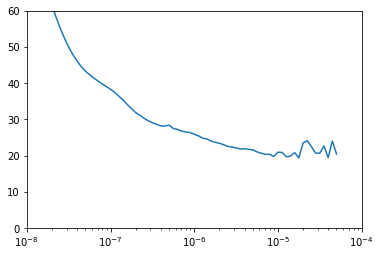

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 35ms/step - loss: 38.9198 - mae: 39.4161
Epoch 2/500
30/30 [==============================] - 1s 35ms/step - loss: 25.7735 - mae: 26.2680
Epoch 3/500
30/30 [==============================] - 1s 35ms/step - loss: 22.0760 - mae: 22.5697
Epoch 4/500
30/30 [==============================] - 1s 37ms/step - loss: 20.4729 - mae: 20.9658
Epoch 5/500
30/30 [==============================] - 1s 36ms/step - loss: 19.7634 - mae: 20.2558
Epoch 6/500
30/30 [==============================] - 1s 36ms/step - loss: 19.3055 - mae: 19.7977
Epoch 7/500
30/30 [==============================] - 1s 35ms/step - loss: 18.7299 - mae: 19.2220
Epoch 8/500
30/30 [==============================] - 1s 36ms/step - loss: 18.1173 - mae: 18.6088
Epoch 9/500
30/30 [==============================] - 1s 36ms/step - loss: 18.1483 - mae: 18.6399
Epoch 10/500
30/30 [==============================] - 1s 36ms/step - loss: 19.7698 - mae: 20.2620
Epoch 11/500
30/30 [=========

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

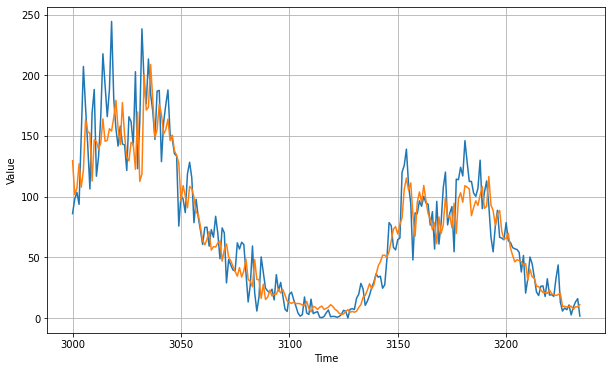

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.298703

<Figure size 432x288 with 0 Axes>

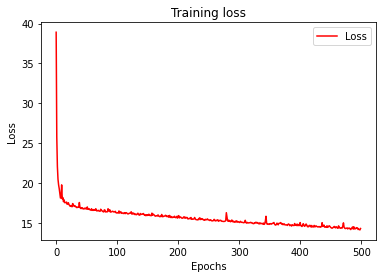

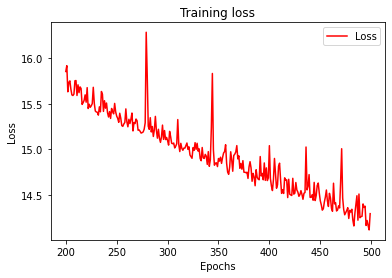

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[129.57413   101.74389   106.96671   127.03484   107.69775   121.81845
 163.67574   153.54906   152.16617   112.78888   146.73602   145.46292
 139.06252   144.13545   164.00275   145.61447   146.35645   155.9128
 154.0263    165.26016   179.37042   156.12907   142.8593    177.45761
 150.59361   132.66586   129.4787    144.72592   143.40175   122.54259
 169.76302   112.5416    118.52287   200.73955   171.30463   173.54243
 208.83366   179.92732   148.64359   155.27428   176.24825   167.70915
 151.4871    155.23012   163.81528   146.13672   150.67644   137.8269
 134.03102   127.518585   96.02368   109.08368   100.5095     90.784195
 108.33208   106.51572    99.425186   87.133194   85.22805    74.95039
  63.97568    60.227276   64.81798    71.213806   55.93039    58.736897
  58.515583   61.794544   63.406586   46.798706   56.269424   61.02281
  50.2418     46.871056   42.539482   38.37567    34.437687   41.495125
  33.67177    38.73776    48.44365    31.723425   30.184803   25.684395
  48

## Exercise 16

For this week’s exercise, you’ll use a dataset from Jason Brownlee, author of the amazing MachineLearningMastery.com site and who has shared lots of datasets at https://github.com/jbrownlee/Datasets. It’s a dataset of daily minimum temperatures in the city of Melbourne, Australia measured from 1981 to 1990.  Your task is to download the dataset, parse the CSV, create a time series and build a prediction model from it. Your model should have an MAE of less than 2, and as you can see in the output, mine had 1.78. I’m sure you can beat that! :)

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /content/daily-min-temperatures.csv

--2021-08-30 05:53:49--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/content/daily-min-temperatures.csv’

/content/daily-min- 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-08-30 05:53:49 (5.64 MB/s) - ‘/content/daily-min-temperatures.csv’ saved [67921/67921]



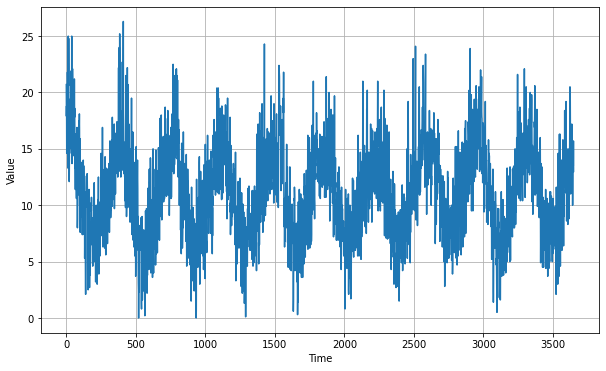

In [5]:
import csv
time_step = []
temps = []

with open('/content/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 4s 54ms/step - loss: 89.9281 - mae: 90.4275
Epoch 2/100
10/10 [==============================] - 1s 56ms/step - loss: 86.6734 - mae: 87.1729
Epoch 3/100
10/10 [==============================] - 1s 60ms/step - loss: 81.7808 - mae: 82.2802
Epoch 4/100
10/10 [==============================] - 1s 55ms/step - loss: 76.0924 - mae: 76.5917
Epoch 5/100
10/10 [==============================] - 1s 59ms/step - loss: 69.9834 - mae: 70.4827
Epoch 6/100
10/10 [==============================] - 1s 56ms/step - loss: 63.5215 - mae: 64.0209
Epoch 7/100
10/10 [==============================] - 1s 60ms/step - loss: 56.6393 - mae: 57.1386
Epoch 8/100
10/10 [==============================] - 1s 59ms/step - loss: 49.2769 - mae: 49.7762
Epoch 9/100
10/10 [==============================] - 1s 59ms/step - loss: 41.4880 - mae: 41.9874
Epoch 10/100
10/10 [==============================] - 1s 59ms/step - loss: 33.8199 - mae: 34.3194
Epoch 11/100
10/10 [=========

(1e-08, 0.0001, 0.0, 60.0)

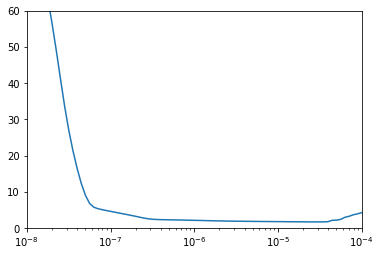

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 5s 35ms/step - loss: 9.9814 - mae: 10.4694
Epoch 2/150
25/25 [==============================] - 1s 35ms/step - loss: 2.5295 - mae: 2.9922
Epoch 3/150
25/25 [==============================] - 1s 36ms/step - loss: 1.9502 - mae: 2.4047
Epoch 4/150
25/25 [==============================] - 1s 36ms/step - loss: 1.8619 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 1s 37ms/step - loss: 1.8215 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 1s 37ms/step - loss: 1.7909 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 1s 37ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 1s 36ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 1s 37ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 1s 36ms/step - loss: 1.7000 - mae: 2.1482
Epoch 11/150
25/25 [============================

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

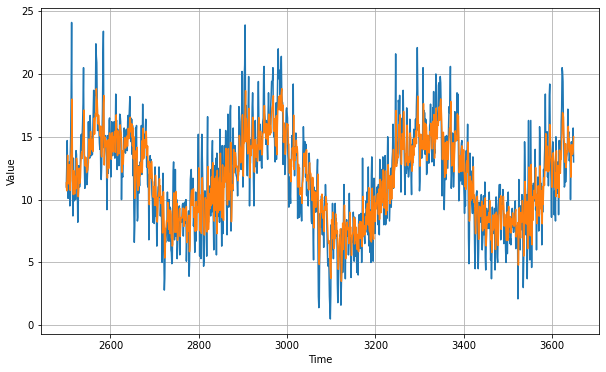

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7796161

In [17]:
print(rnn_forecast)

[11.329479  10.7055645 12.124861  ... 13.604185  13.796462  15.008996 ]
